In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scvi
import scanpy as sc
import anndata as an
import scanpy.external as sce
import scipy
import scipy.sparse as sp
import time
import sklearn
import torch
from scipy.sparse import csr_matrix

from importlib import reload

# local imports
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3 

In [2]:
print(torch.version.cuda) 

12.0


In [3]:
num_processors = os.cpu_count()
print(f"Number of processors: {num_processors}") 

Number of processors: 64


In [4]:
# Check CUDA availability
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")

    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")

        # Additional information (compute capability, memory)
        gpu_props = torch.cuda.get_device_properties(i)
        print(f"  Compute Capability: {gpu_props.major}.{gpu_props.minor}")
        print(f"  Total Memory: {gpu_props.total_memory / 1024**3:.2f} GB")
else:
    print("CUDA not available. Running on CPU.")

CUDA available: True
Number of GPUs: 1
GPU 0: NVIDIA A100 80GB PCIe MIG 3g.40gb
  Compute Capability: 8.0
  Total Memory: 39.25 GB


In [5]:
# Check JAX
import jax
print(jax.devices())

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]


# Load data

In [6]:
def load_annotations(fpath):
    """
    Loads annotations data from a CSV file, processes it, and returns the resulting DataFrame.

    Args:
        fpath (str): The file path to the CSV file containing annotations data.

    Returns:
        pd.DataFrame: The processed DataFrame with 'cell_id' as the index.
    """
    df = pd.read_csv(fpath)
    df['cell_id'] = df['obs_index'].astype(str) + "_" + df["dataset"]
    df = df.drop(columns='dataset')
    df = df.set_index('cell_id')
    return df

In [7]:
"""
DATA
"""
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/merged_anndata/merged_adata.h5ad"
adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
print(adata)

"""
ANNOTATIONS
"""
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/annotation/cell_types.csv"
df = load_annotations(fpath)
df = df[df.index.isin(adata.obs_names)]
print(f"{df.shape=}")

adata.obs = pd.concat([adata.obs, df], ignore_index=False, axis=1)
adata

Memory usage: current 8.73 GB, difference +8.73 GB
AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'
df.shape=(171498, 3)


AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

# Annotations

In [8]:
# fpaths = [
#     "../resources/PanglaoDB_Augmented_2021.txt",
#     "../resources/Tabula_Sapiens.txt",
# ]

# marker_columns = []

# for fpath in fpaths:    
#     features = ut.load_pathway(fpath)

#     # extract columns
#     hsc_columns = [x for x in features.columns if "hemato" in x.lower()]
#     fib_columns = [x for x in features.columns if "fibroblast" in x.lower()]
#     fib_columns = [x for x in fib_columns if not "myofibr" in x.lower()]
    
#     columns = list(set(hsc_columns + fib_columns))

#     for col in columns:
#         gene_list = list(features[features[col].astype(bool)].index)
#         print(col, len(gene_list))
#         col_name = col.lower().replace("-", " ")
#         col_name = col_name.replace(" ", "_") + "_marker"
#         marker_columns.append(col_name)
#         adata.var[col_name] = adata.var.index.isin(gene_list)
    
# adata.var['is_marker'] = adata.var[marker_columns].any(axis=1)
# print()
# adata

# Randomly subsample the tabula sapiens fibroblast data

In [9]:
# sample_size = 1e4 # the numbner of fibroblast signatures to keep

# mask = (adata.obs['dataset'] == 'tabula_sapiens') & (adata.obs['standard_cell_type'] == 'Fib')

# print(f"Filtering for Fibroblasts from tabula_sapiens dataset...")
# fibdf = adata.obs[mask].copy()
# print(f"Found {len(fibdf)} fibroblasts.")

# print(f"Sampling {sample_size} fibroblasts...")
# keep = fibdf.sample(int(sample_size))
# keep = keep.index
# print("Sampling complete.")

# fib_to_drop = fibdf[~fibdf.index.isin(keep)].index
# all_keep = ~adata.obs.index.isin(fib_to_drop)

# # Print the lengths
# print(f"Total fibroblasts: {len(adata.obs.index)}")
# print(f"Fibroblasts to keep: {len(keep)}")
# print(f"Fibroblasts to drop: {len(fib_to_drop)}") 

# adata = adata[all_keep, :].copy()  
# adata

# Cell type filtering

In [10]:
cell_types = [
    # 'PreBNK', - only preent in single batch
    # 'LinNeg', - only preent in single batch
    'HSC',
    'CMP',
    'MEP',
    'MPP',
    'GMP',
    # 'MLP', - only preent in single batch
    'EryP',
    'MDP',
    'MKP',
    # 'Mono',
    'CLP',
    # 'T_cell',
    # 'B_cell',
    # 'NK',
    'LMPP',
    # 'Dendritic_cell',
    'Fib',
    'iHSC',
]

adata = adata[adata.obs['standard_cell_type'].notna(), :].copy()
adata = adata[adata.obs['standard_cell_type'].isin(cell_types), :].copy()

adata.obs['standard_cell_type'].value_counts()

standard_cell_type
Fib     34289
HSC     20789
EryP     9902
MPP      9391
iHSC     8379
MEP      7433
GMP      4882
MDP      3989
MKP      3980
CLP      3640
CMP      2804
LMPP      805
Name: count, dtype: int64

# Preprocessing

In [11]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=250)

adata

filtered out 7095 cells that have less than 1000 genes expressed
filtered out 1498 genes that are detected in less than 250 cells


AnnData object with n_obs × n_vars = 103188 × 17369
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells'
    layers: 'counts'

In [12]:
# Normalizing to median total counts
target_sum = 1e4
sc.pp.normalize_total(adata, target_sum=target_sum)
sc.pp.log1p(adata)
adata.layers["log_norm"] = csr_matrix(adata.X.astype('float32').copy())

adata

normalizing counts per cell
    finished (0:00:01)


AnnData object with n_obs × n_vars = 103188 × 17369
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells'
    uns: 'log1p'
    layers: 'counts', 'log_norm'

# Make reference and query data

In [13]:
reference_data = [
    'tabula_sapiens',
    'weng_young2_all',
    'sc_fib',
    'weng_young1_all_t2',
    'weng_young1_all_t1',
]

query_data = [
    'iHSC',
]

sample_size = None

# define data sets
rdata = adata[adata.obs['dataset'].isin(reference_data), :].copy()
if not sample_size is None:
    sc.pp.subsample(rdata, n_obs=sample_size)

print(rdata)
print()
qdata = adata[adata.obs['dataset'].isin(query_data), :].copy()
print(qdata)

AnnData object with n_obs × n_vars = 78594 × 17369
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells'
    uns: 'log1p'
    layers: 'counts', 'log_norm'

AnnData object with n_obs × n_vars = 8131 × 17369
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells'
    uns: 'log1p'
    layers: 'counts', 'log_norm'


In [14]:
rdata.obs['cell_label'] = rdata.obs['standard_cell_type'].apply(lambda x: str(x).strip())
rdata.obs['cell_label'].value_counts()

cell_label
Fib     33710
HSC     14639
MPP      7459
MEP      5142
EryP     4927
CLP      3125
MKP      3120
GMP      2537
MDP      2064
CMP      1155
LMPP      716
Name: count, dtype: int64

In [15]:
qdata.obs['cell_label'] = 'Unknown'
qdata.obs['cell_label'].value_counts()

cell_label
Unknown    8131
Name: count, dtype: int64

# Store the Data

In [16]:
output_path = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/full_data.h5ad"
fdata = an.concat([rdata, qdata], label="batch")
fdata.write(fpath)
fdata

AnnData object with n_obs × n_vars = 86725 × 17369
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', 'batch'
    layers: 'counts', 'log_norm'

# Feature Selection

In [17]:
n_genes = 5000

rdata.raw = rdata
sc.pp.highly_variable_genes(
    rdata, 
    n_top_genes=n_genes,
    batch_key="dataset", 
    layer='log_norm',
)

# actually subset the data
rdata = rdata[:, rdata.var['highly_variable']].copy()

rdata

extracting highly variable genes
    finished (0:00:10)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 78594 × 7500
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'log_norm'

In [18]:
rdata.X = rdata.X.toarray()
rdata

AnnData object with n_obs × n_vars = 78594 × 7500
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'log_norm'

# Reference Mapping (scANVI)

In [19]:
scvi.model.SCVI.setup_anndata(
    rdata, 
    batch_key="dataset",
    layer="counts",
    labels_key='cell_label',
)

In [20]:
torch.cuda.empty_cache()

epochs = 400

model = scvi.model.SCVI(
    rdata,
    use_layer_norm="both",
    use_batch_norm="none",
    n_latent=12,
    encode_covariates=True,
    dropout_rate=0.3,
    n_layers=2,
)

start_time = time.time()  # Record the start time

model.train(
    max_epochs=epochs,
    accelerator='gpu',
    devices='auto',
    enable_model_summary=True,
    early_stopping=True,
    batch_size=10000,
)

end_time = time.time()  # Record the end time
total_time = end_time - start_time  # Calculate total execution time

print(f"Training completed in {total_time:.2f} seconds")

# Optional: More detailed timing information
minutes = int(total_time // 60)
seconds = int(total_time % 60)
print(f"Training time: {minutes} minutes {seconds} seconds")

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium'

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


Training completed in 3371.77 seconds
Training time: 56 minutes 11 seconds


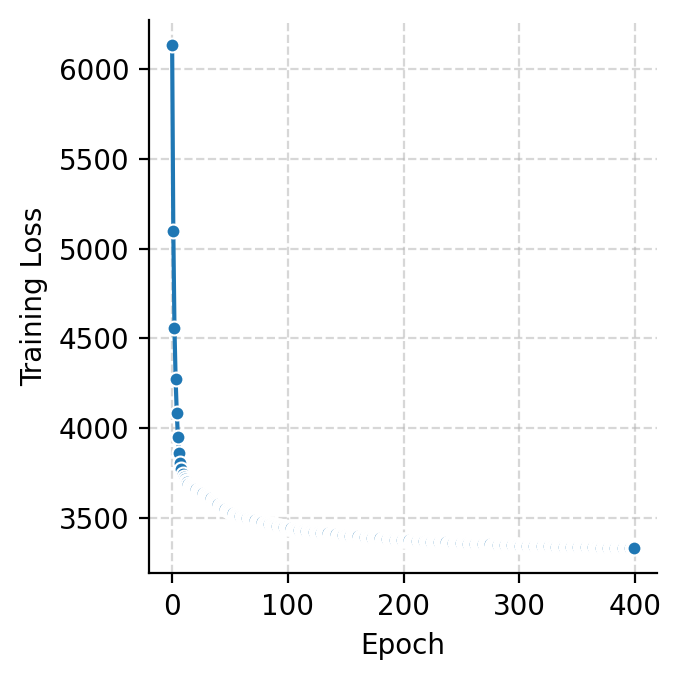

In [21]:
metrics = pd.concat(
    model.history.values(), 
    ignore_index=False,
    axis=1
)

metrics = metrics.reset_index()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 3.5

sns.lineplot(
    data=metrics,
    x='epoch',
    y='train_loss_epoch',
    linewidth=1.5,                        
    markersize=5
)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks()
plt.yticks()
plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid

sns.despine()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# SCVI Latent Space

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:27)
running Leiden clustering


/tmp/ipykernel_3144719/1048822739.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


    finished: found 21 clusters and added
    'scvi_clusters', the cluster labels (adata.obs, categorical) (0:00:09)
computing UMAP


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_umap.py:231: FutureWarning: `method='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  warnings.warn(msg, FutureWarning)


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


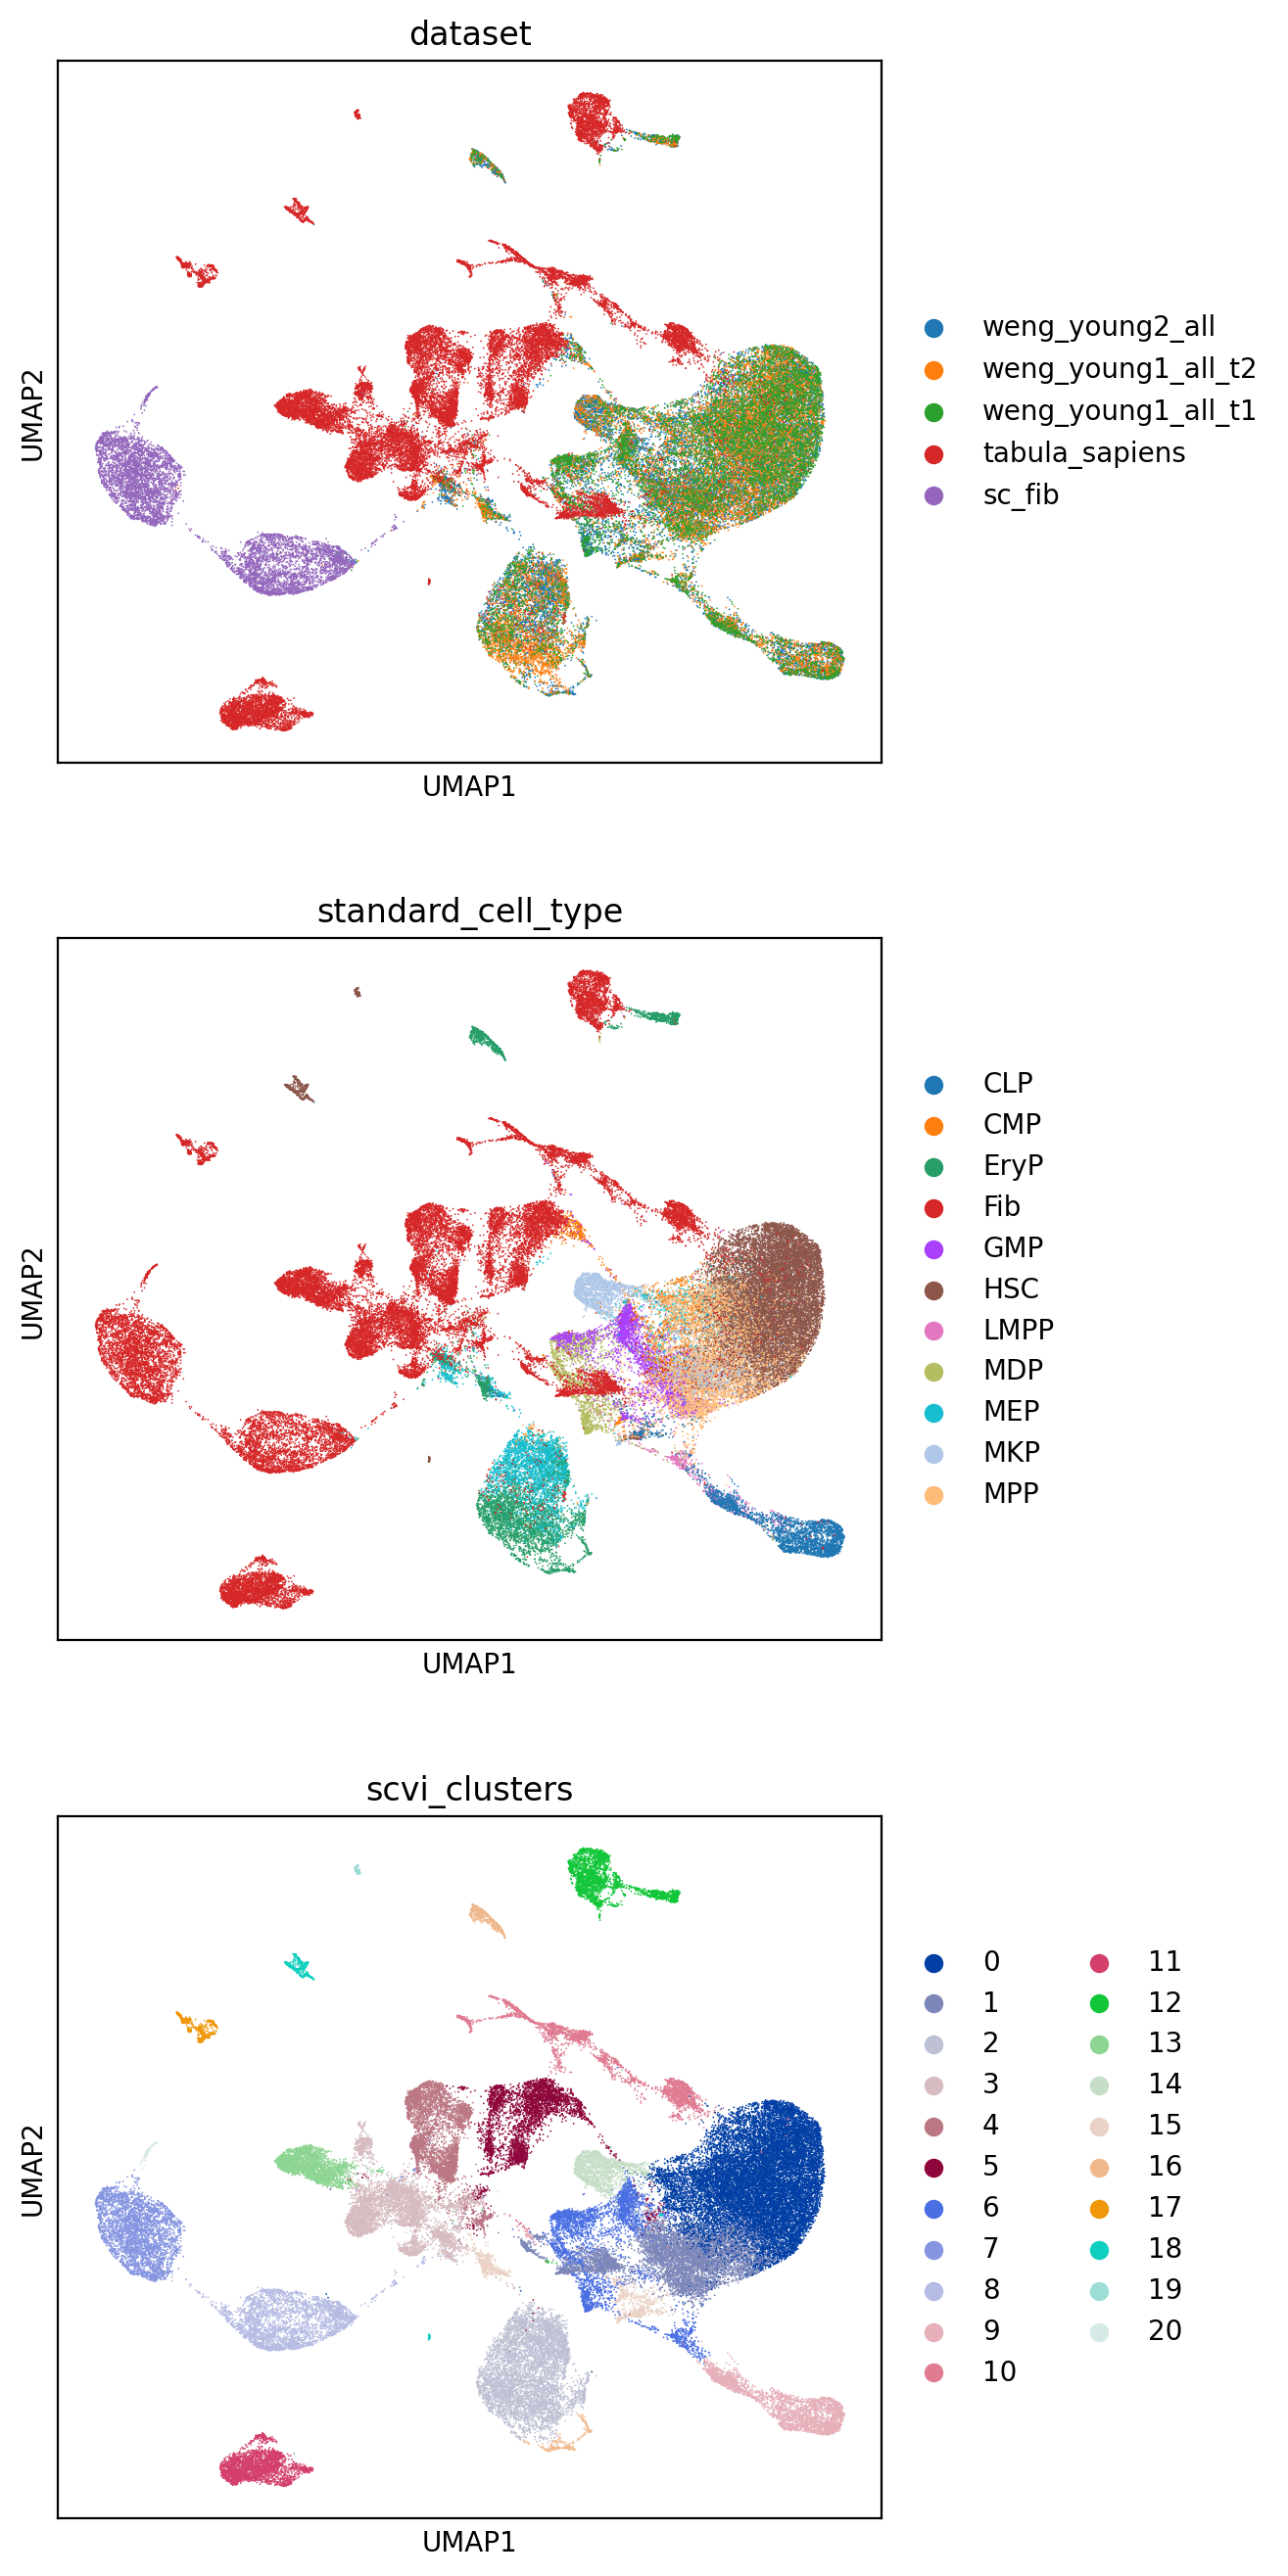

In [22]:
SCVI_LATENT_KEY = "X_scVI"
rdata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

sc.pp.neighbors(
    rdata, 
    use_rep=SCVI_LATENT_KEY,
)

sc.tl.leiden(
    rdata, 
    resolution=0.3,
    key_added='scvi_clusters',
)

sc.tl.umap(
    rdata,
    min_dist=0.25,
    method='rapids',
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(
    rdata, 
    color=[
        'dataset',
        'standard_cell_type',
        'scvi_clusters',
    ],
    ncols=1,
)

In [23]:
# break

# SCANVI Model

In [24]:
torch.cuda.empty_cache()

# train the scanvi model
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model, 
    unlabeled_category="Unknown",
)

epochs = 400

start_time = time.time()  # Record the start time

scanvi_model.train(
    max_epochs=epochs,
    accelerator='gpu',
    devices='auto',
    enable_model_summary=True,
    early_stopping=True,
    batch_size=10000,
)

end_time = time.time()  # Record the end time
total_time = end_time - start_time  # Calculate total execution time

print(f"Training completed in {total_time:.2f} seconds")

# Optional: More detailed timing information
minutes = int(total_time // 60)
seconds = int(total_time % 60)
print(f"Training time: {minutes} minutes {seconds} seconds")

INFO     Training for 400 epochs.                                                                                  


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-b0322fd2-c5fa-58ce-9ae8-321051669590]

  | Name            | Type                | Params | Mode 
---------------------------------

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


Training completed in 6491.70 seconds
Training time: 108 minutes 11 seconds


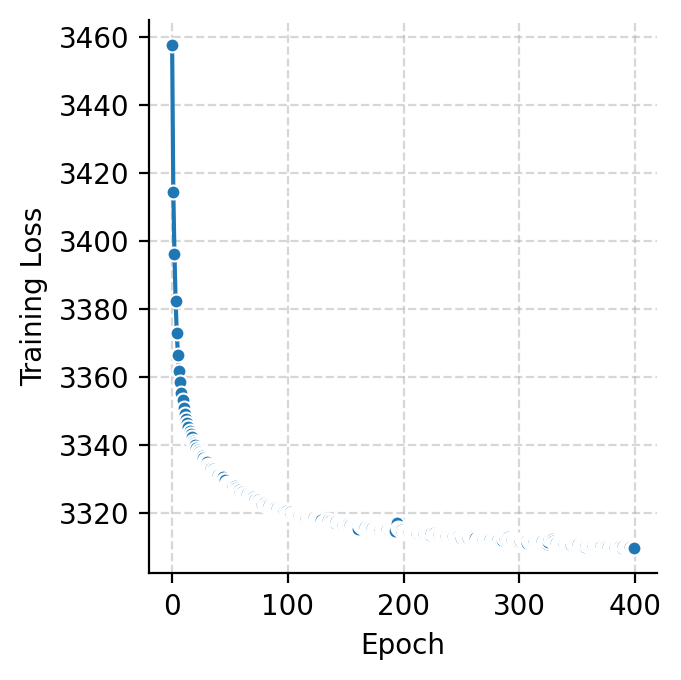

In [25]:
metrics = pd.concat(
    scanvi_model.history.values(), 
    ignore_index=False,
    axis=1
)
metrics = metrics.reset_index()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 3.5

sns.lineplot(
    data=metrics,
    x='epoch',
    y='train_loss_epoch',
    linewidth=1.5,                       
    markersize=5
)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks()
plt.yticks()
plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid

sns.despine()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Latent Representations (SCANVI)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
running Leiden clustering
    finished: found 25 clusters and added
    'scanvi_clusters', the cluster labels (adata.obs, categorical) (0:00:05)
computing UMAP


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_umap.py:231: FutureWarning: `method='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  warnings.warn(msg, FutureWarning)


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


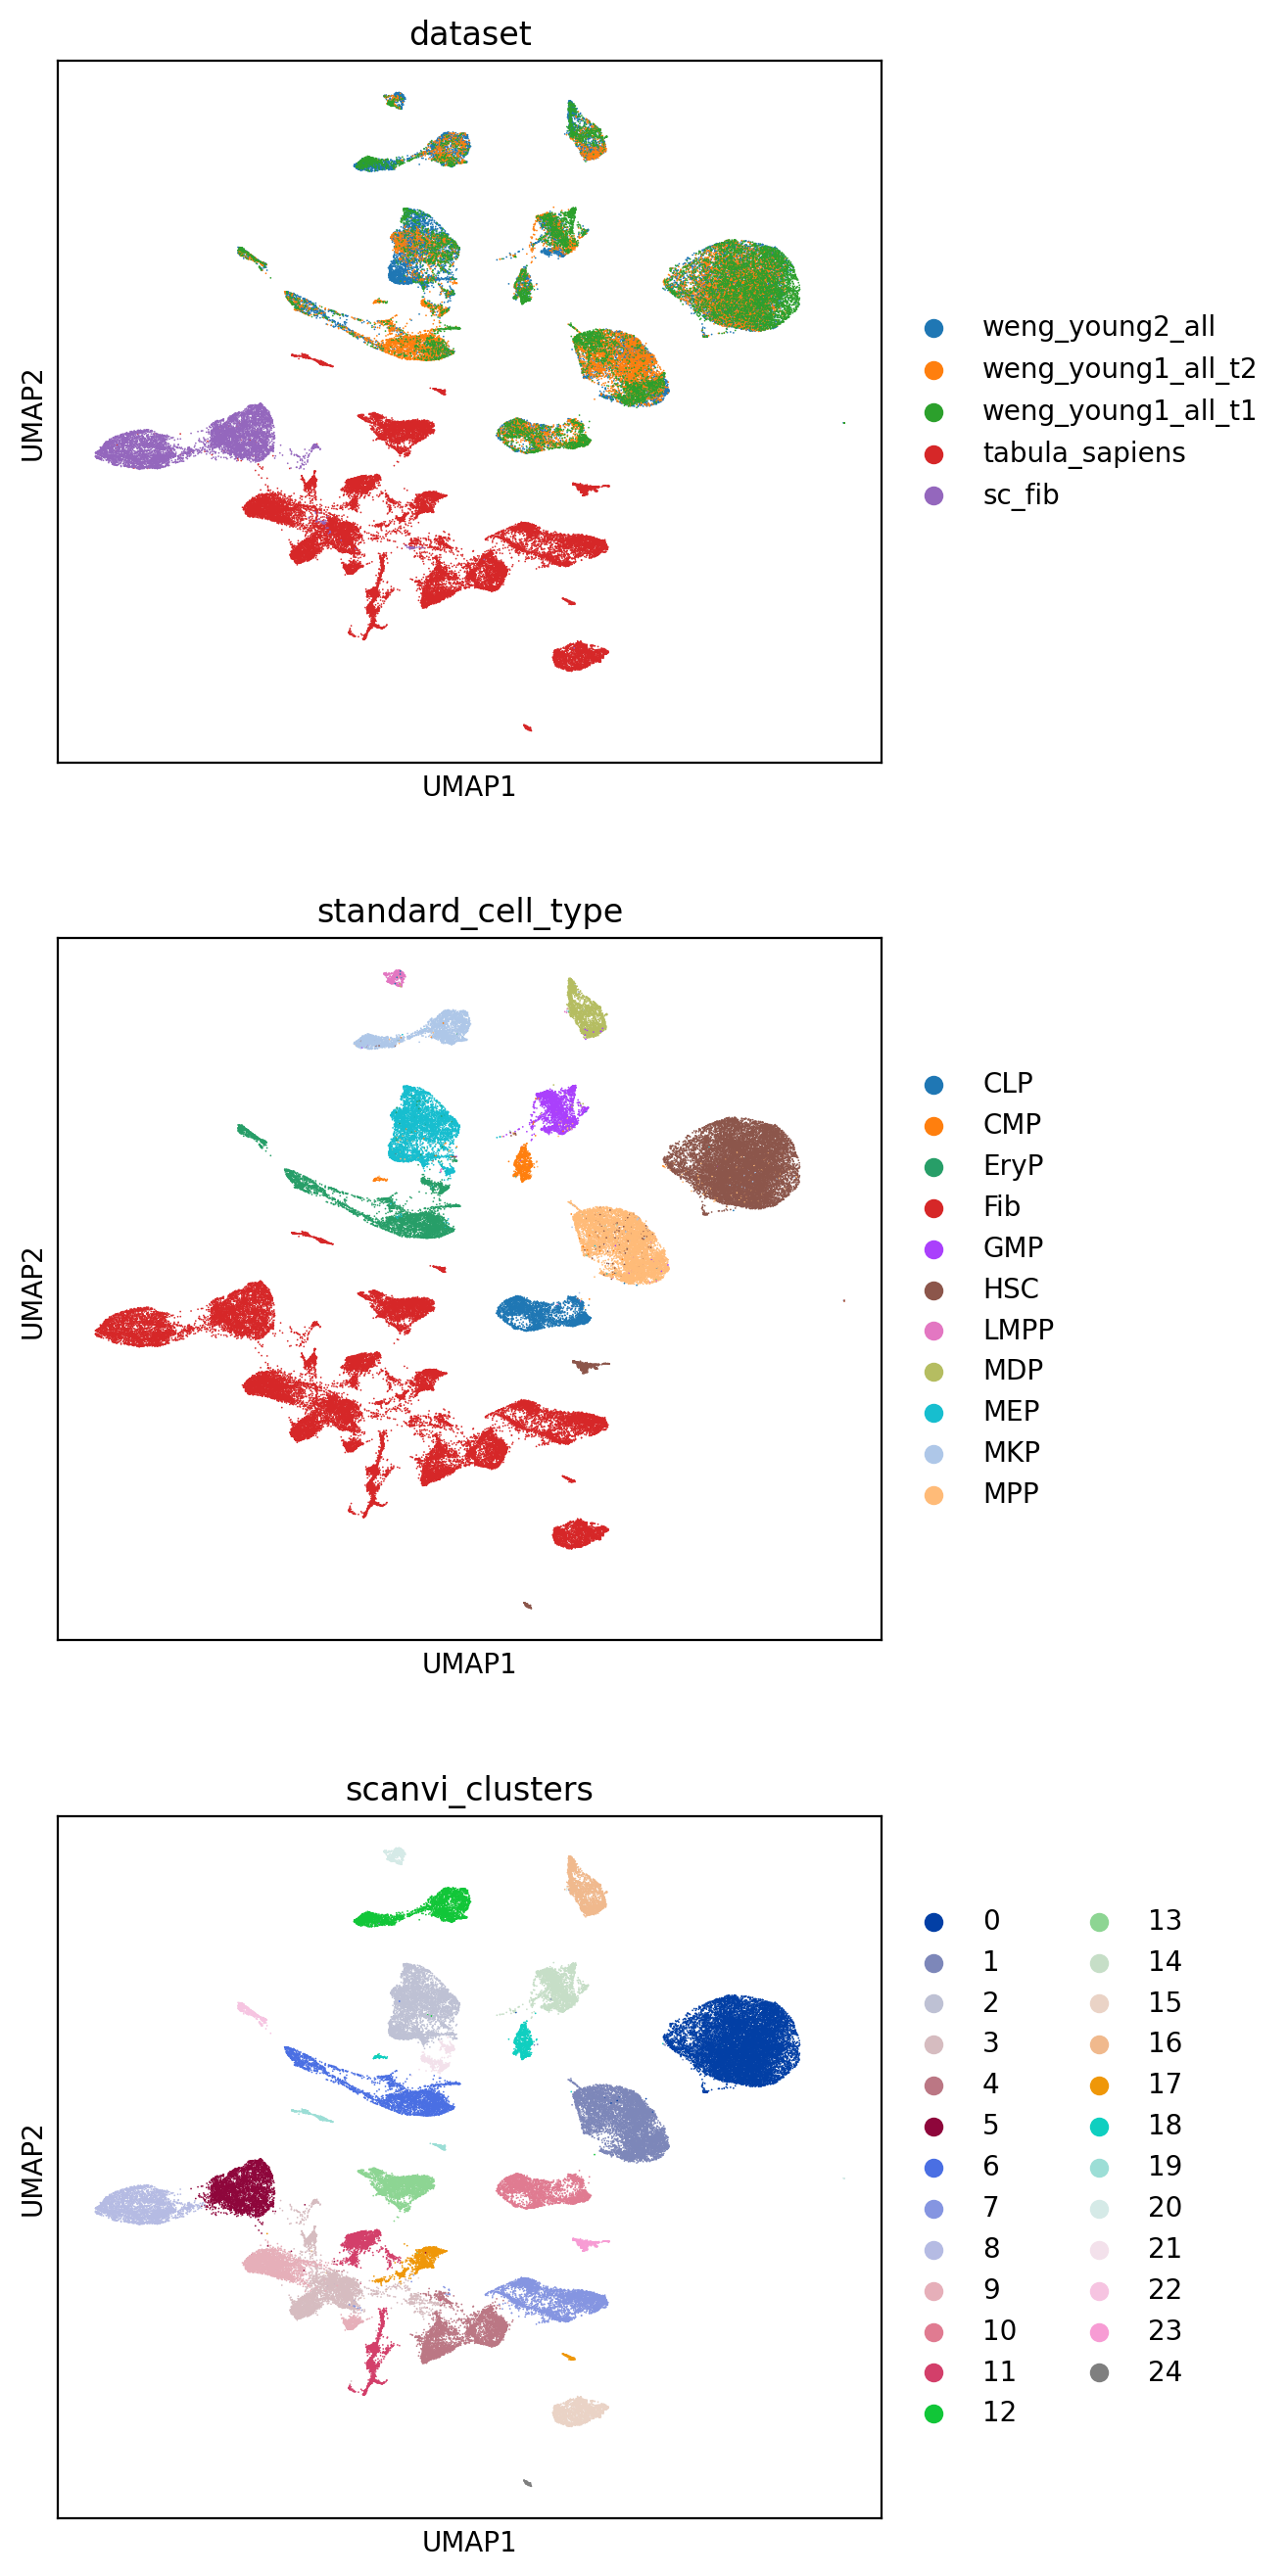

In [26]:
SCANVI_LATENT_KEY = "X_scANVI"

rdata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation()

sc.pp.neighbors(
    rdata, 
    use_rep=SCANVI_LATENT_KEY,
)

sc.tl.leiden(
    rdata, 
    resolution=0.3,
    key_added='scanvi_clusters',
)

sc.tl.umap(
    rdata,
    min_dist=0.25,
    method='rapids',
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(
    rdata, 
    color=[
        'dataset',
        'standard_cell_type',
        'scanvi_clusters',
    ],
    ncols=1,
)

In [27]:
rdata.layers['SCANVI_counts'] = scanvi_model.get_normalized_expression(return_mean=False)
rdata

AnnData object with n_obs × n_vars = 78594 × 7500
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'scvi_clusters', 'scanvi_clusters'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'scvi_clusters', 'umap', 'dataset_colors', 'standard_cell_type_colors', 'scvi_clusters_colors', 'scanvi_clusters', 'scanvi_clusters_colors'
    obsm: 'X_scVI', 'X_umap', 'X_scANVI'
    layers: 'counts', 'log_norm', 'SCANVI_counts'
    obsp: 'distances', 'connectivities'

# Save the model (SCANVI only)

In [28]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/model/"
scanvi_model.save(
    fpath, 
    overwrite=True, 
    save_anndata=True,
    prefix='reference_'
) 
print('done')

done


# Benchmarking

computing PCA
    with n_comps=50


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:22)


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Embeddings: 100%|██████████| 3/3 [12:03<00:00, 241.31s/it]tch correction: pcr_comparison]

                                                                                         

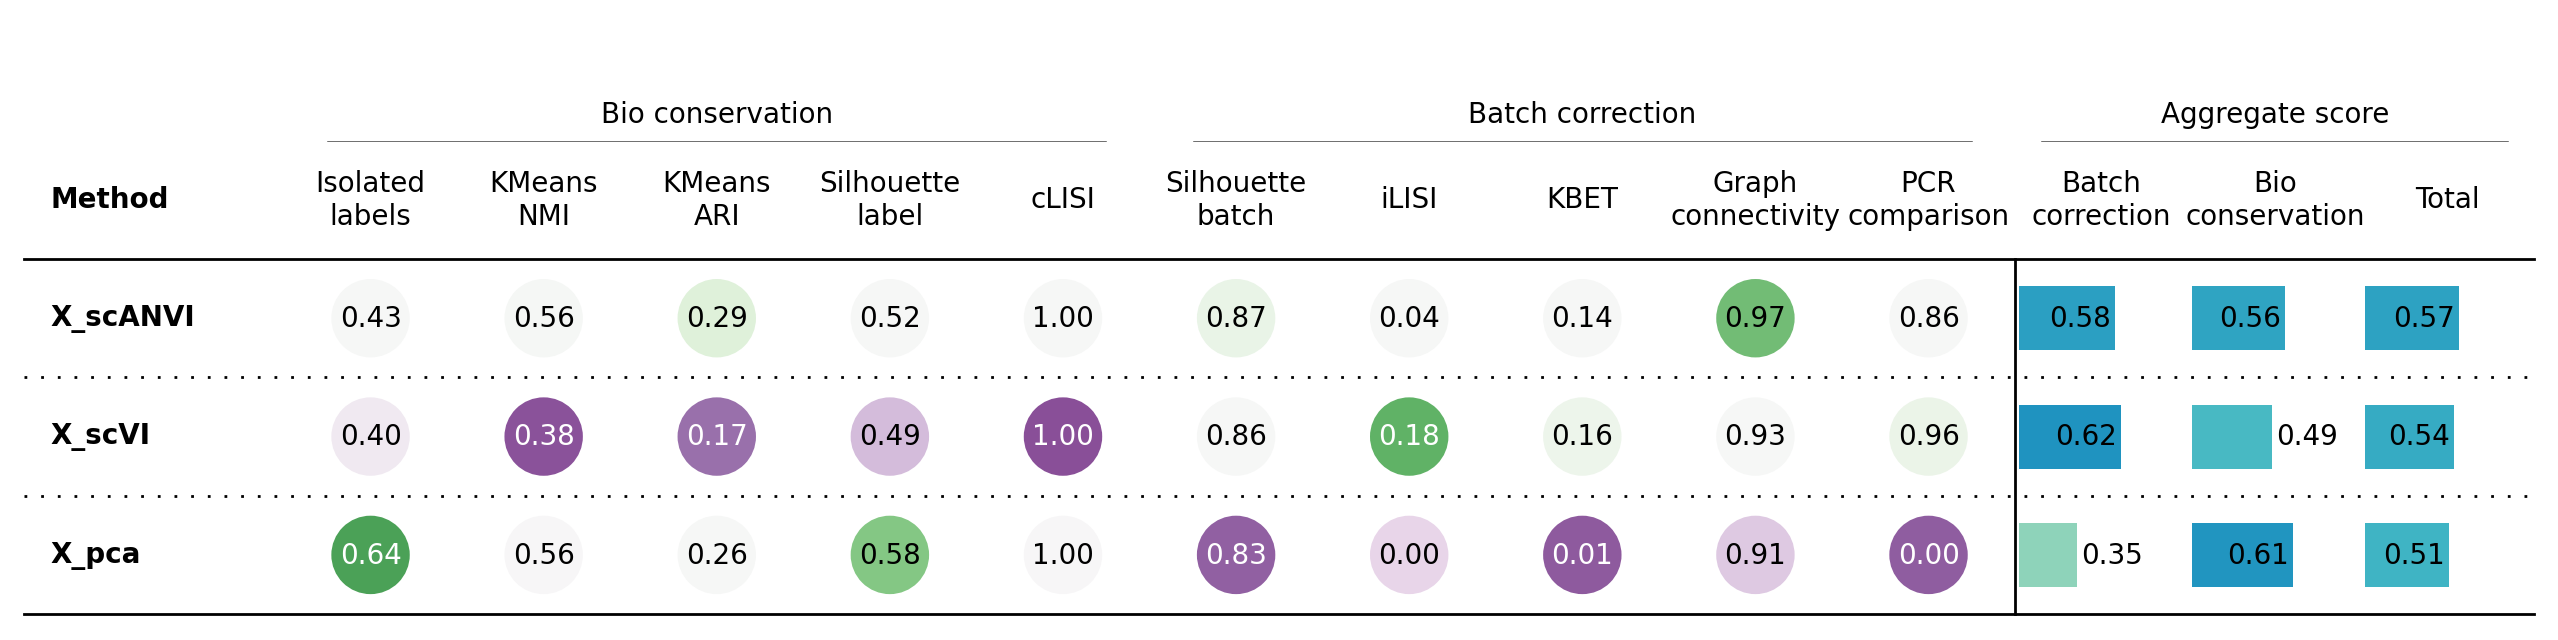

In [29]:
from scib_metrics.benchmark import Benchmarker

torch.cuda.empty_cache()

bm = Benchmarker(
    rdata,
    batch_key="dataset",
    label_key="cell_label",
    embedding_obsm_keys=['X_pca', SCVI_LATENT_KEY, SCANVI_LATENT_KEY],
)

bm.benchmark()

bm.plot_results_table(min_max_scale=False)

In [30]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/benchmarks.csv"
bmdf = bm.get_results(min_max_scale=False)
bmdf = bmdf.reset_index(drop=False,)
bmdf.to_csv(fpath, index=False,)
bmdf.head()

,Embedding,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
0,X_pca,0.641647,0.560777,0.264186,0.580412,1.0,0.828434,0.000432,0.014421,0.905308,0.0,0.349719,0.609404,0.50553
1,X_scVI,0.398347,0.382075,0.16519,0.487629,0.998169,0.864448,0.176837,0.15801,0.926932,0.961331,0.617512,0.486282,0.538774
2,X_scANVI,0.426587,0.563862,0.29002,0.522852,1.0,0.869626,0.043545,0.144881,0.974825,0.857727,0.578121,0.560664,0.567647
3,Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


# Query mapping (SCANVI)

In [31]:
scvi.model.SCANVI.prepare_query_anndata(
    qdata, 
    scanvi_model,
)

scanvi_query = scvi.model.SCANVI.load_query_data(
    qdata, 
    scanvi_model,
)

print('Done!')

torch.cuda.empty_cache()

epochs = 15

SCANVI_PREDICTIONS_KEY = "predictions_scanvi"

scanvi_query.train(
    max_epochs=epochs, 
    plan_kwargs={"weight_decay": 0.01},
)

qdata.obsm[SCANVI_LATENT_KEY] = scanvi_query.get_latent_representation()
qdata.layers['SCANVI_counts'] = scanvi_query.get_normalized_expression(return_mean=False)
qdata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_query.predict()

qdata

INFO     Found 100.0% reference vars in query data.                                                                
Done!
INFO     Training for 15 epochs.                                                                                   


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is n

Training:   0%|          | 0/15 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


AnnData object with n_obs × n_vars = 8131 × 7500
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'predictions_scanvi'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scANVI'
    layers: 'counts', 'log_norm', 'SCANVI_counts'

In [32]:
"""ADD SCVI LATENT SPACE AS WELL"""

scvi.model.SCVI.prepare_query_anndata(
    qdata, 
    model,
)

scvi_query = scvi.model.SCVI.load_query_data(
    qdata, 
    model,
)

epochs = 15

scvi_query.train(
    max_epochs=epochs, 
    plan_kwargs={"weight_decay": 0.01},
)

qdata.obsm[SCVI_LATENT_KEY] = scvi_query.get_latent_representation()
qdata

INFO     Found 100.0% reference vars in query data.                                                                


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is n

Training:   0%|          | 0/15 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


AnnData object with n_obs × n_vars = 8131 × 7500
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'predictions_scanvi'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scANVI', 'X_scVI'
    layers: 'counts', 'log_norm', 'SCANVI_counts'

# Store Query Model (SCANVI only)

In [33]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/model/"
scanvi_query.save(
    fpath, 
    overwrite=True, 
    save_anndata=True,
    prefix='query_'
) 
print('done')

done


# Predicted Probability

In [34]:
pred_proba = scanvi_query.predict(soft=True)
pred_proba.head()

,CLP,CMP,EryP,Fib,GMP,HSC,LMPP,MDP,MEP,MKP,MPP
AAACCCAAGGTTACCT_iHSC,3.204298e-07,8.398259e-07,4.360017e-08,0.999961,1.640486e-07,0.000033,2.397121e-06,2.310343e-07,8.981290e-08,6.601230e-07,8.394672e-07
AAACCCAAGTTGAAGT_iHSC,9.329545e-08,3.337065e-07,1.005048e-07,0.999981,9.311377e-08,0.000017,1.135867e-06,1.655427e-07,7.521622e-08,5.085806e-07,1.898438e-07
AAACCCAAGTTGTCGT_iHSC,3.605770e-08,8.316373e-07,4.157100e-08,0.999994,1.539074e-07,0.000002,5.535642e-07,1.016847e-06,2.119476e-08,1.099634e-06,1.576799e-07
AAACCCACAGAAGCGT_iHSC,8.865186e-08,3.540681e-07,8.460381e-08,0.999988,6.538124e-08,0.000010,7.840750e-07,1.282896e-07,9.546051e-08,3.613487e-07,1.916219e-07
AAACCCACAGGAGGTT_iHSC,1.379182e-07,5.151754e-07,3.867421e-08,0.999992,9.080942e-08,0.000006,8.996608e-07,1.907637e-07,3.282419e-08,4.754834e-07,1.672724e-07


<Axes: xlabel='HSC', ylabel='Count'>

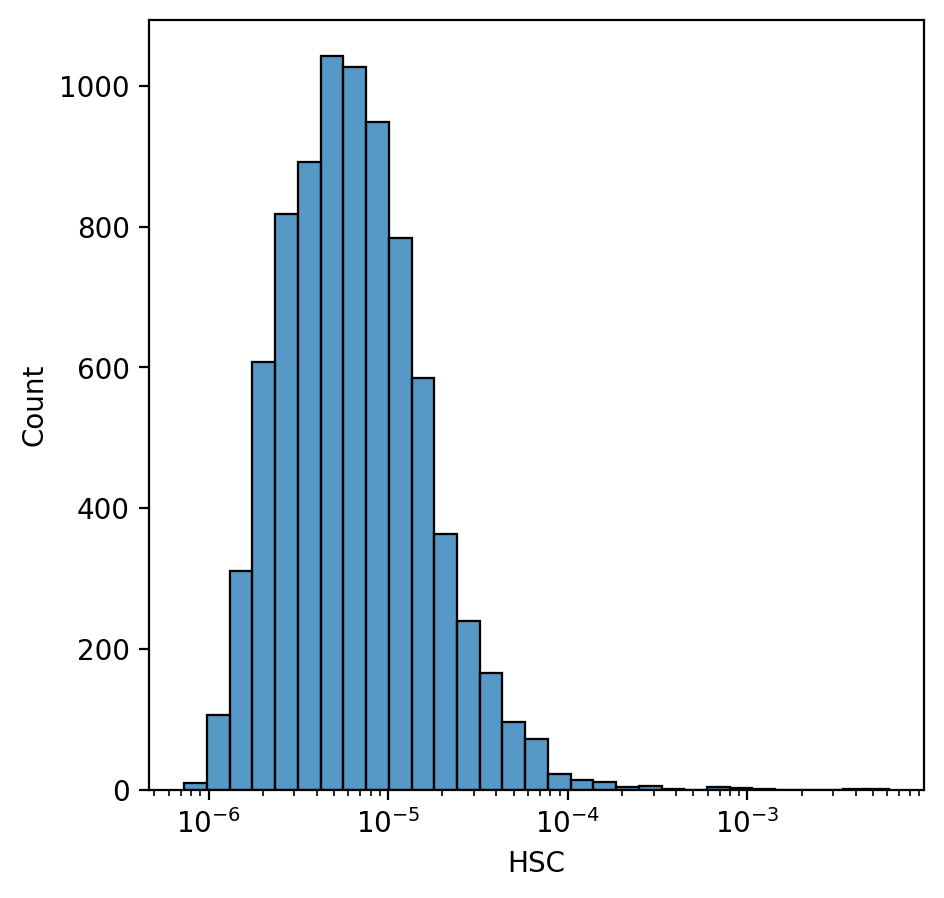

In [35]:
sns.histplot(
    data=pred_proba,
    x='HSC',
    log_scale=True,
    bins=31,
)

In [36]:
preds = scanvi_query.predict()
pd.value_counts(preds)

Fib    8131
Name: count, dtype: int64

# Store predictions

In [37]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/ihsc_predictions.csv"
df = pred_proba.copy()
df = df.astype(float)
df['prediction'] = df.idxmax(axis=1)
df = df.reset_index(drop=False, names='cell_id')

df.to_csv(fpath, index=False,)

df.head()

,cell_id,CLP,CMP,EryP,Fib,GMP,HSC,LMPP,MDP,MEP,MKP,MPP,prediction
0,AAACCCAAGGTTACCT_iHSC,3.204298e-07,8.398259e-07,4.360017e-08,0.999961,1.640486e-07,0.000033,2.397121e-06,2.310343e-07,8.981290e-08,6.601230e-07,8.394672e-07,Fib
1,AAACCCAAGTTGAAGT_iHSC,9.329545e-08,3.337065e-07,1.005048e-07,0.999981,9.311377e-08,0.000017,1.135867e-06,1.655427e-07,7.521622e-08,5.085806e-07,1.898438e-07,Fib
2,AAACCCAAGTTGTCGT_iHSC,3.605770e-08,8.316373e-07,4.157100e-08,0.999994,1.539074e-07,0.000002,5.535642e-07,1.016847e-06,2.119476e-08,1.099634e-06,1.576799e-07,Fib
3,AAACCCACAGAAGCGT_iHSC,8.865186e-08,3.540681e-07,8.460381e-08,0.999988,6.538124e-08,0.000010,7.840750e-07,1.282896e-07,9.546051e-08,3.613487e-07,1.916219e-07,Fib
4,AAACCCACAGGAGGTT_iHSC,1.379182e-07,5.151754e-07,3.867421e-08,0.999992,9.080942e-08,0.000006,8.996608e-07,1.907637e-07,3.282419e-08,4.754834e-07,1.672724e-07,Fib


# Integrate

In [38]:
fdata = an.concat([rdata, qdata], label="batch")
fdata

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/merge.py:1357: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


AnnData object with n_obs × n_vars = 86725 × 7500
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch'
    obsm: 'X_scANVI', 'X_scVI'
    layers: 'counts', 'log_norm', 'SCANVI_counts'

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_umap.py:231: FutureWarning: `method='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  warnings.warn(msg, FutureWarning)


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


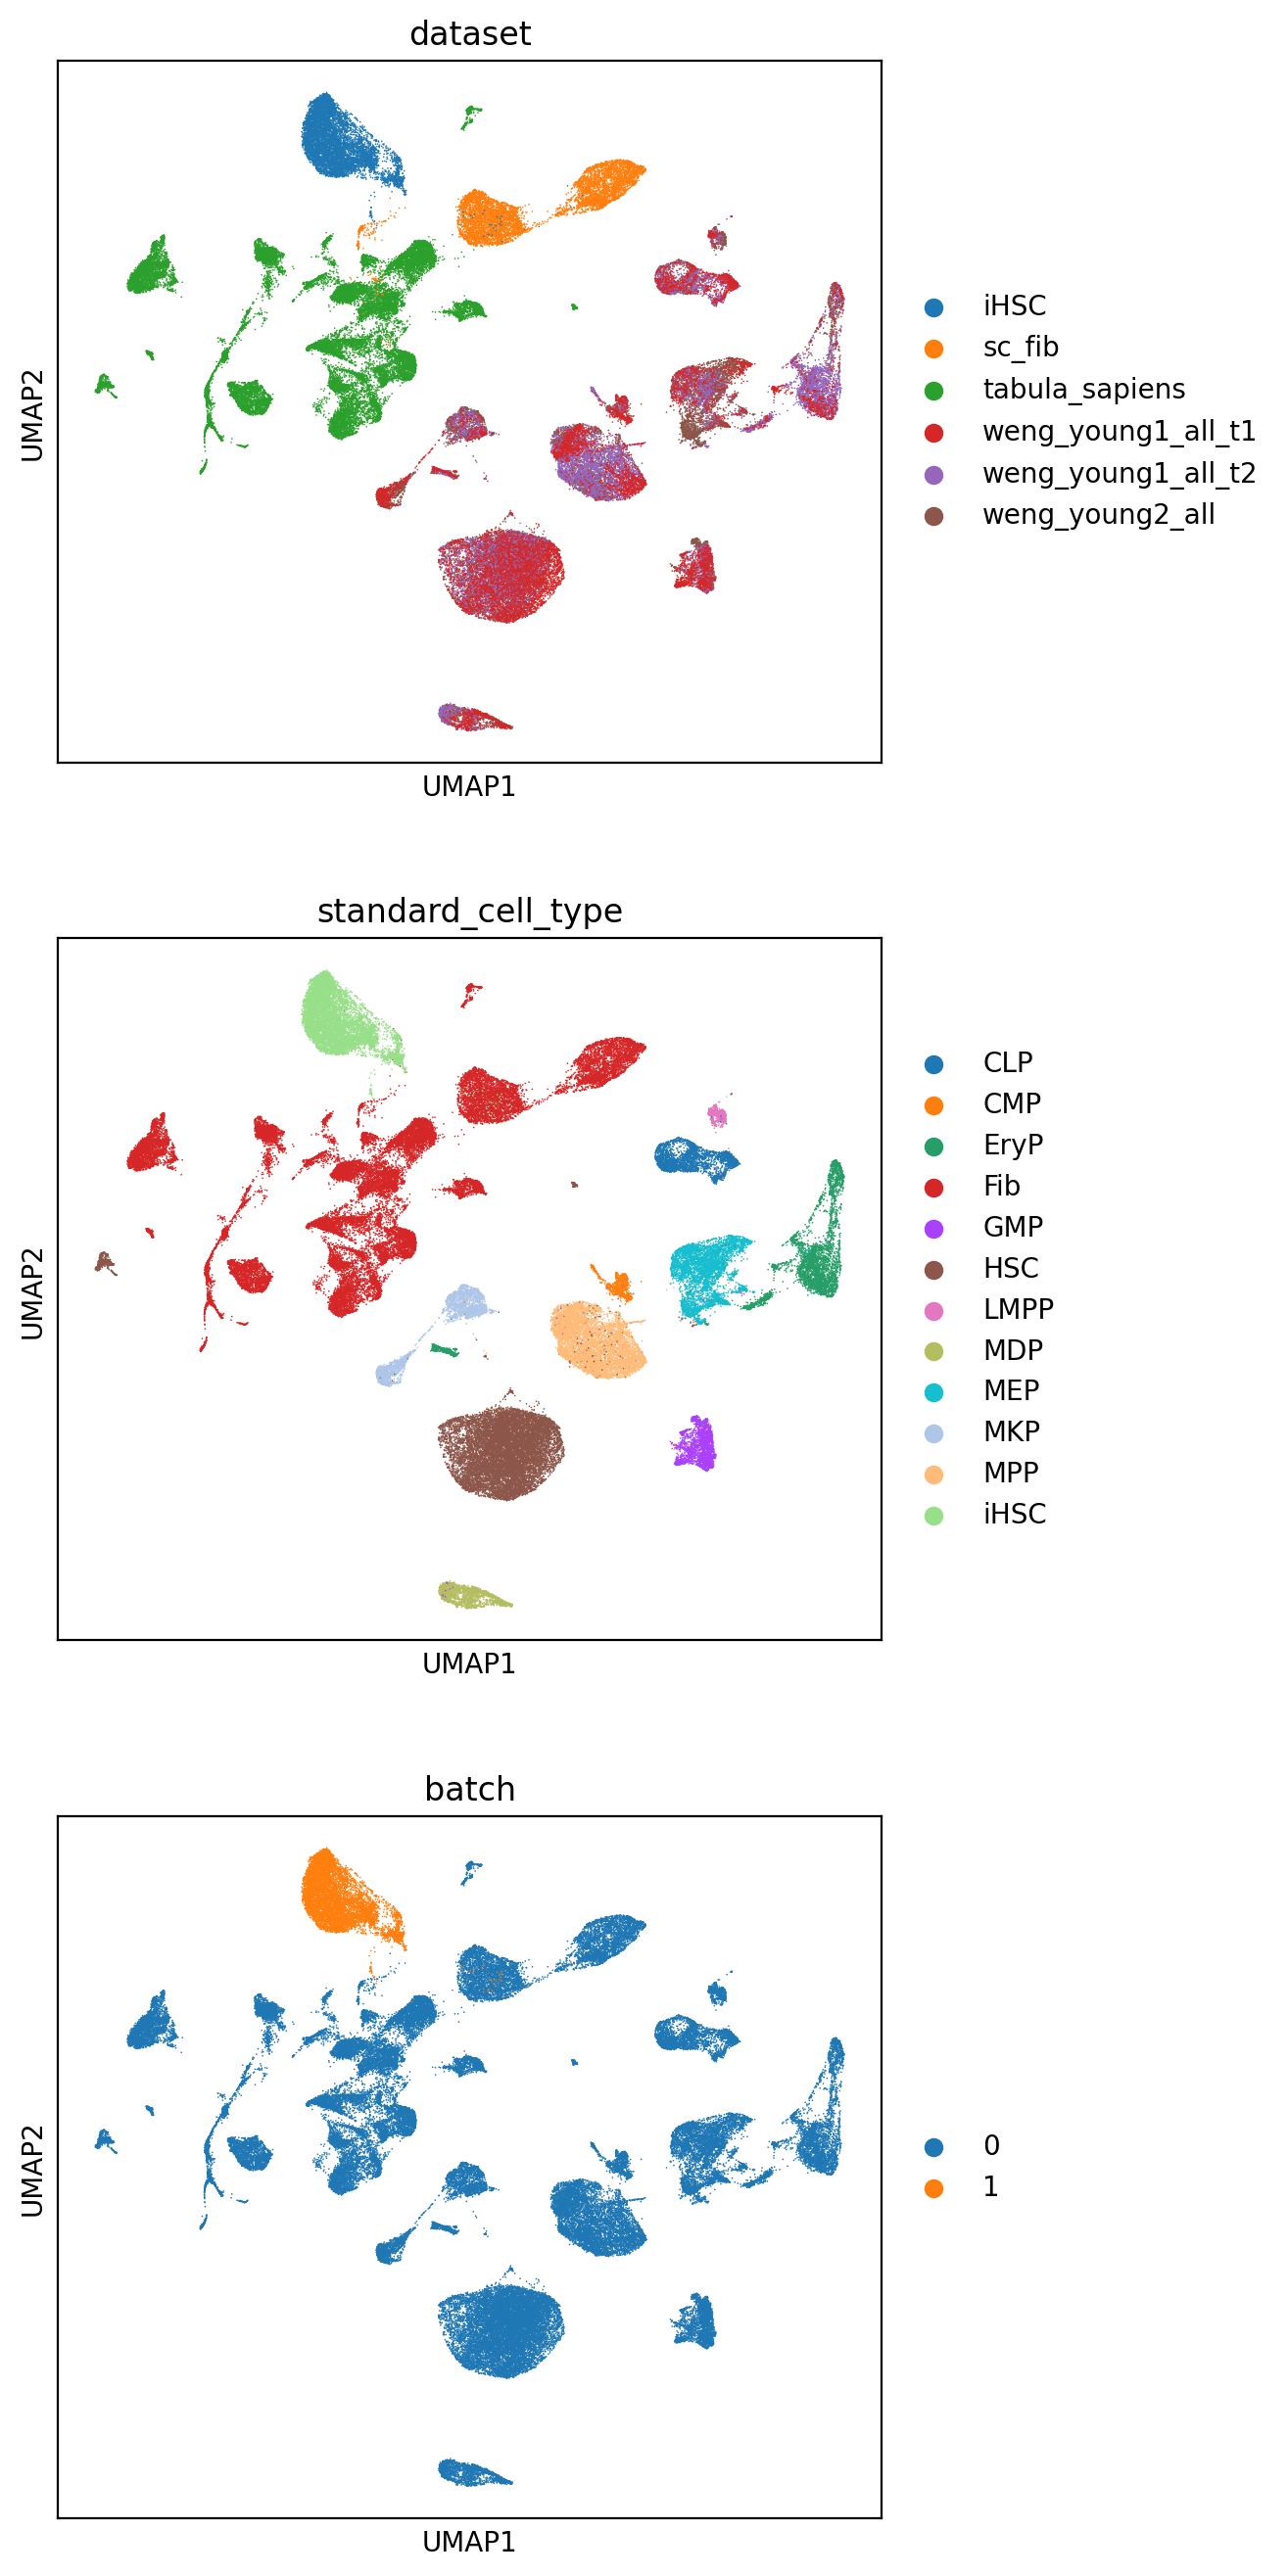

In [39]:
sc.pp.neighbors(
    fdata, 
    use_rep=SCANVI_LATENT_KEY,
)

sc.tl.umap(
    fdata,
    min_dist=0.25,
    method='rapids',
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(
    fdata, 
    color=[
        'dataset',
        'standard_cell_type',
        'batch',
    ],
    ncols=1,
)

# Store ADATA

In [40]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/imputed_data.h5ad"
fdata.write(fpath)
fdata

AnnData object with n_obs × n_vars = 86725 × 7500
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch'
    uns: 'neighbors', 'umap', 'dataset_colors', 'standard_cell_type_colors', 'batch_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts', 'log_norm', 'SCANVI_counts'
    obsp: 'distances', 'connectivities'